In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

In [2]:

# Fourier Transformation Utility Functions using NumPy
def fft2(u):
    return np.fft.fftshift(np.fft.fft2(u))

def ifft2(u_hat):
    return np.fft.ifft2(np.fft.ifftshift(u_hat))


# Central Fractional Derivatives

def Dx_central(u, alpha):
    u_hat = fft2(u)
    M, N = u.shape

    size = M
    middle_row_index = size//2
    matrix = np.zeros((size, size), dtype=int)
    # if n is odd
    for i in range(middle_row_index):
        if (size%2) :
            matrix[i] = - size + i +1 + middle_row_index
        else :
            matrix[i] = - size + i + middle_row_index
    for i in range(middle_row_index + 1, size):
        matrix[i] = + i - middle_row_index 

    x = np.power(1 - np.exp(-1j*2*np.pi * matrix/M), alpha)
    z = np.power(np.exp(1j*np.pi * matrix/M), alpha)
    dx_hat = u_hat * x * z
    dx = ifft2(dx_hat)
    return dx

def Dy_central(u, alpha):
    u_hat = fft2(u)
    M, N = u.shape
    size = N
    array_x, array_y = np.mgrid[0:M,0:N]

    middle_row_index = size//2
    matrix = np.zeros((size, size), dtype=int)
    # if n is odd
    for i in range(middle_row_index):
        if (size%2) :
            matrix[:,i] = - size + i +1 + middle_row_index
        else :
            matrix[:,i] = - size + i + middle_row_index
    for i in range(middle_row_index + 1, size):
        matrix[:,i] = + i - middle_row_index 

    y = np.power(1 - np.exp(-1j*2*np.pi * matrix/N), alpha)
    z = np.power(np.exp(1j*np.pi * matrix/N), alpha)
    dy_hat = u_hat * y * z
    dy = ifft2(dy_hat)
    return dy

# Diffusion Coefficient Computation
def C(u, alpha):
    # Precompute all required derivatives
    dx_alpha = Dx_central(u, alpha)
    dy_alpha = Dy_central(u, alpha)

    # Compute D using the real part of derivatives for alpha
    D = np.square(dx_alpha.real) + np.square(dy_alpha.real)

    # Calculate c
    c = 1 / (1 + D)
    
    return c

# Compute Kx and Ky using NumPy
def make_K(M, N, alpha):
    w1,w2 = np.mgrid[0:M, 0:N]
    w1_grid = w1 - (M/2)*np.ones((M,N))
    w2_grid = w2 - (N/2)*np.ones((M,N))
    Kx = np.power(1 - np.exp(-1j*2*np.pi * w1_grid/M), alpha)*np.power(np.exp(1j*np.pi * w1_grid/M), alpha)
    Ky = np.power(1 - np.exp(-1j*2*np.pi * w2_grid/N), alpha)*np.power(np.exp(1j*np.pi * w2_grid/N), alpha)
    return Kx, Ky


def saveImg(img, file_path):
    """
    Saves the image to the specified file path after normalizing it. 
    If the image is 3D with identical color channels, it converts it to grayscale before saving.
    
    param img: The input image, can be 2D or 3D array.
    param file_path: The path where to save the image, including the file name and extension.
    """
    # Check if img is a 2D grayscale or a 3D RGB where all channels are identical
    if len(img.shape) == 3 and np.all(img[:, :, 0] == img[:, :, 1]) and np.all(img[:, :, 1] == img[:, :, 2]):
        # If 3D RGB with identical channels, take the first channel to convert to grayscale
        img = img[:, :, 0]

    # Normalize the image to 0-1 range if it's not already in uint8 format
    if img.dtype != np.uint8:
        img = (img - np.min(img)) / (np.max(img) - np.min(img))

    # Save the image
    mpimg.imsave(file_path, img, cmap='gray')

In [3]:
# Simulation Parameters
alpha = 1.3
dt = 0.01

# Image Loading and Noise Addition
u_clean = cv2.imread('barbara.png', cv2.IMREAD_GRAYSCALE)
mean = 0
mu = 7
std = (mu * np.max(u_clean))/100
noise = np.random.normal(mean, std, u_clean.shape)
u_noisy = u_clean + noise
u = u_noisy.copy()

# Compute Kx and Ky
M, N = u.shape
Kx, Ky = make_K(M, N, alpha)

# Denoising Loop
i = 0
prev_PSNR = cv2.PSNR(u_clean.astype('float32'), u.astype('float32'))
while True:
    i += 1

    u_hat = fft2(u)
    c = C(u, alpha)
    # print(c)
    gx = c * Dx_central(u, alpha)
    gy = c * Dy_central(u, alpha)

    gx_hat = fft2(gx)
    gy_hat = fft2(gy)

    # Compute the combined g_hat using the conjugates of Kx and Ky
    g_hat = (np.conj(Kx) * gx_hat) + (np.conj(Ky) * gy_hat)

    # Perform iteration
    u_hat = u_hat - g_hat * dt
    u = ifft2(u_hat).real

    current_PSNR = cv2.PSNR(u_clean.astype('float32'), u.astype('float32'))
    print(f"Iteration {i}", current_PSNR - prev_PSNR)
    if prev_PSNR > current_PSNR :
        break
    else:
        prev_PSNR = current_PSNR
        u_denoised = u.copy()  # Update denoised image after the loop

    u_denoised = u_denoised.real
    

Iteration 1 0.0002677489355882301
Iteration 2 0.00026781681503607047
Iteration 3 0.0002678301247591719
Iteration 4 0.00026787128862437726
Iteration 5 0.00026792992273527716
Iteration 6 0.0002679475011859722
Iteration 7 0.00026801315920366164
Iteration 8 0.00026803487985560537
Iteration 9 0.0002680906532219751
Iteration 10 0.00026811052152453385
Iteration 11 0.0002681556859478462
Iteration 12 0.00026821640866003804
Iteration 13 0.000268233705149612
Iteration 14 0.0002682919585339505
Iteration 15 0.00026833770572309845
Iteration 16 0.0002683768818378951
Iteration 17 0.00026842325836184955
Iteration 18 0.0002684502847678516
Iteration 19 0.00026849190686206725
Iteration 20 0.00026855508458467625
Iteration 21 0.0002686135468543682
Iteration 22 0.00026863096136509057
Iteration 23 0.00026866746677711717
Iteration 24 0.00026874478337646224
Iteration 25 0.0002687736242172889
Iteration 26 0.00026881558361679936
Iteration 27 0.00026888080920883795
Iteration 28 0.0002688914439410439
Iteration 29 0

KeyboardInterrupt: 

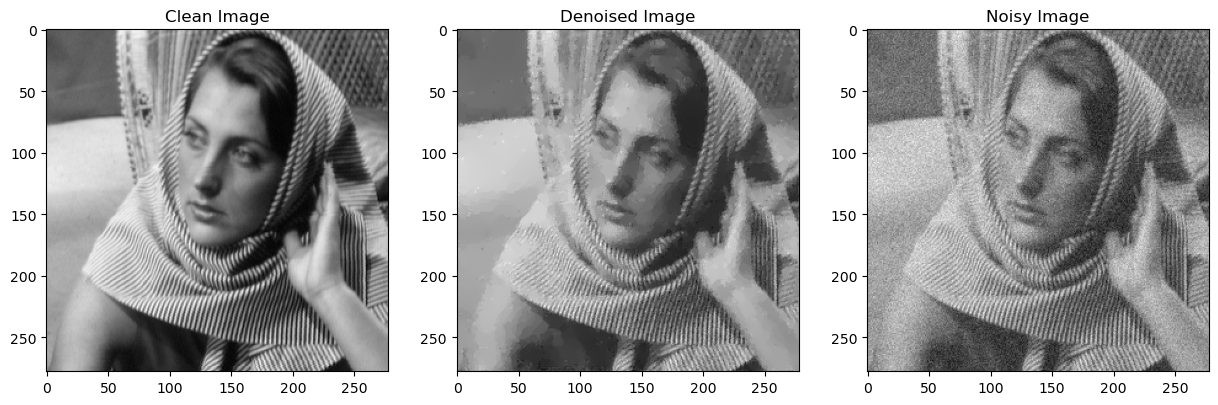

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image
ax1.imshow(u_clean, cmap='gray')
ax1.set_title('Clean Image')

# Plot the denoised image
ax2.imshow(u_denoised, cmap='gray')
ax2.set_title('Denoised Image')

# Plot the noisy image
ax3.imshow(u_noisy, cmap='gray')
ax3.set_title('Noisy Image')

plt.show()

In [15]:
saveImg(u_denoised,"./output/Squared/1_3_squared.png")